## Python Google Trends API

* https://towardsdatascience.com/google-trends-api-for-python-a84bc25db88f
* https://pypi.org/project/pytrends/
* https://github.com/GeneralMills/pytrends#installation
* https://www.honchosearch.com/blog/seo/how-to-use-python-pytrends-to-automate-google-trends-data/

In [96]:
#!python3.8 -m pip install pytrends
#!python3.8 -m pip install plotly

     |████████████████████████████████| 13.2 MB 4.3 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=af1231f305ed61536cbbe9bc27b247ab85aa5922959391506df11e8a1489fb49
  Stored in directory: /Users/joan/Library/Caches/pip/wheels/c4/a7/48/0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying
You should consider upgrading via the '/opt/anaconda3/bin/python3.8 -m pip install --upgrade pip' command.


In [146]:
'''
imports
'''
import pandas as pd   
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import scipy.signal
import numpy as np
from scipy.signal import find_peaks

## Environment Variables and Authentication

In [151]:
'''
GLOBAL ENVIRONMENT GOOGLE TREND VARIABLES
'''
# Get Dataframe with desired keyoword trend search
pytrend = TrendReq()
kw_list=['ahorro consumo energetico', 'ahorro corriente', 'ahorro energia', 'energia solar', 'placas solares'] #, 'energia fotovoltaica', 'energia solar fotovoltaica', 'placa energia solar']
directory = "/Users/joan/Workspace/python/py-trends-api/"
timeframe = 'all' # 'today 5-y'
geo_location='ES' # specific country location España
year_start = 2021
year_end = 2021
month_start = 6
month_end = 6
day_start = 1
day_end = 7
hour_start = 0
hour_end = 23

## Searching for Trends

In [335]:
'''
Test just 1 keyword and store into CSV, month by month to get hourly to avoid timeouts
'''
df = pytrend.get_historical_interest(kw_list, year_start=year_start, month_start=month_start, day_start=day_start, hour_start=hour_start, year_end=year_end, month_end=month_end, day_end=day_end, hour_end=hour_end, cat=0, geo=geo_location, gprop='', sleep=0)
df.describe

<bound method NDFrame.describe of                      ahorro consumo energetico  ahorro corriente  \
date                                                               
2021-06-01 00:00:00                          0                 0   
2021-06-01 01:00:00                          0                 0   
2021-06-01 02:00:00                          0                 0   
2021-06-01 03:00:00                          0                 0   
2021-06-01 04:00:00                          0                 0   
...                                        ...               ...   
2021-06-07 19:00:00                          0                 0   
2021-06-07 20:00:00                          0                 0   
2021-06-07 21:00:00                          0                 1   
2021-06-07 22:00:00                          0                 0   
2021-06-07 23:00:00                          0                 0   

                     ahorro energia  energia solar  placas solares  isPartial  
d

## Processing Data

In [336]:
# Tidy up IsPartial column for data overtime, eliminates the rows with isPartial == true
# and then drop the column isPartial, when all values are false
def partial(df, n_file):
    for i in range(n_file-1):
        df = df.drop(columns="isPartial."+str(i+1)+"")
    if df.isPartial.tail(1).bool() == True:
        df = df.drop(df.isPartial.tail(1).index, axis=0)
    df = df.drop(columns="isPartial")
    return df

In [337]:
# Convert date index to new column date
df.reset_index(inplace=True)

# Tidy up isPartial data (estimated)
df = partial(df,1)

# Cast date object column into datetime column
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%dT%H:%M:%SZ')

# Split date into year, month, day and hour
df['year'], df['month'], df['day'], df['hour'] = df['date'].apply(lambda x: x.year), df['date'].apply(lambda x: x.month), df['date'].apply(lambda x: x.day), df['date'].apply(lambda x: x.hour)

# Drop date column
#df = df.drop(columns="date") # will be needed for predictions, it is better to filter in a new dataframe

# Interest statistics
#df['googleInterest'] = df[kw_list[0]]

# Transpose column name with keywords kw_list[i] into a column value within a new column named 'keyword'
#df['keyword'] = kw_list[0]
#df = df.drop(columns=kw_list[0])

# Add location column
df['geo_location'] = geo_location # geo_location translated to spanish description from ISO2 ES code

# Calculate the min interest
df['min_interest'] = df[df.columns[1:6]].min(axis=1) # Horitzontal min for the keyword columns

# Calculate the max interest
df['max_interest'] = df[df.columns[1:6]].max(axis=1) # Horitzontal max for the keyword columns

# Calculate the average interest
df['avg_interest'] = df[df.columns[1:6]].mean(axis=1) # Horitzontal mean for the keyword columns

df.head()

,date,ahorro corriente,ahorro energia,energia solar,placas solares,year,month,day,hour,googleInterest,keyword,location
0,2021-06-01 00:00:00,0,4,6,37,2021,6,1,0,0,ahorro consumo energetico,España
1,2021-06-01 01:00:00,0,0,3,38,2021,6,1,1,0,ahorro consumo energetico,España
2,2021-06-01 02:00:00,0,4,20,33,2021,6,1,2,0,ahorro consumo energetico,España
3,2021-06-01 03:00:00,0,0,15,47,2021,6,1,3,0,ahorro consumo energetico,España
4,2021-06-01 04:00:00,0,0,17,59,2021,6,1,4,0,ahorro consumo energetico,España
...,...,...,...,...,...,...,...,...,...,...,...,...
163,2021-06-07 19:00:00,0,2,11,53,2021,6,7,19,0,ahorro consumo energetico,España
164,2021-06-07 20:00:00,0,1,11,57,2021,6,7,20,0,ahorro consumo energetico,España
165,2021-06-07 21:00:00,1,2,11,50,2021,6,7,21,0,ahorro consumo energetico,España
166,2021-06-07 22:00:00,0,2,12,41,2021,6,7,22,0,ahorro consumo energetico,España


In [338]:
# Save Dataset into CSV file
df.to_csv(directory + 'df_google_historical_interest_'+geo_location+'.csv', index = False)

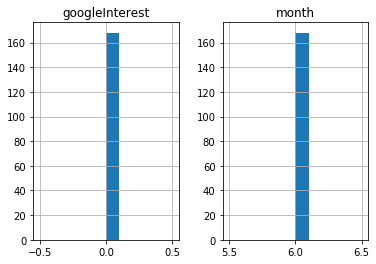

Text(0, 0.5, 'googleInterest')

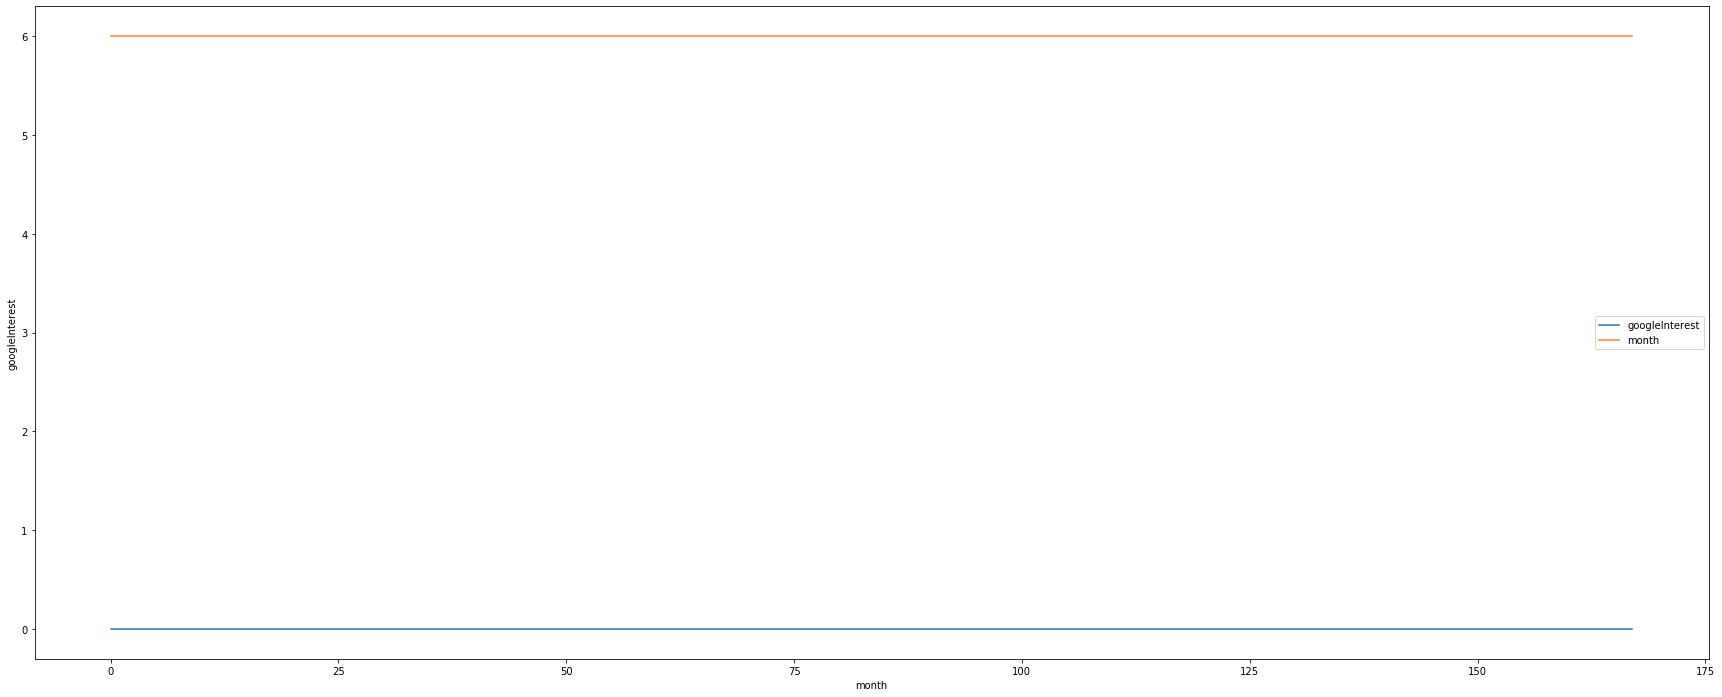

In [339]:
# Visualize data, are there peaks to be detected?
trend_df = df[['googleInterest','month']]
trend_df.hist()
plt.show()

trend_df.plot(figsize=(30, 12))
plt.xlabel('month')
plt.ylabel('googleInterest')

In [340]:
time_series = df['googleInterest']
indices = find_peaks(time_series, threshold=20)[0]

In [341]:
# Visualize peaks with plotly

fig = go.Figure()
fig.add_trace(go.Scatter(
    y=time_series,
    mode='lines+markers',
    name='Original Plot'
))

fig.add_trace(go.Scatter(
    x=indices,
    y=[time_series[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        symbol='cross'
    ),
    name='Detected Peaks'
))

fig.show()

In [342]:
df

,date,ahorro corriente,ahorro energia,energia solar,placas solares,year,month,day,hour,googleInterest,keyword,location
0,2021-06-01 00:00:00,0,4,6,37,2021,6,1,0,0,ahorro consumo energetico,España
1,2021-06-01 01:00:00,0,0,3,38,2021,6,1,1,0,ahorro consumo energetico,España
2,2021-06-01 02:00:00,0,4,20,33,2021,6,1,2,0,ahorro consumo energetico,España
3,2021-06-01 03:00:00,0,0,15,47,2021,6,1,3,0,ahorro consumo energetico,España
4,2021-06-01 04:00:00,0,0,17,59,2021,6,1,4,0,ahorro consumo energetico,España
...,...,...,...,...,...,...,...,...,...,...,...,...
163,2021-06-07 19:00:00,0,2,11,53,2021,6,7,19,0,ahorro consumo energetico,España
164,2021-06-07 20:00:00,0,1,11,57,2021,6,7,20,0,ahorro consumo energetico,España
165,2021-06-07 21:00:00,1,2,11,50,2021,6,7,21,0,ahorro consumo energetico,España
166,2021-06-07 22:00:00,0,2,12,41,2021,6,7,22,0,ahorro consumo energetico,España


## Data visualisation and Regression Model and Prediction

In [ ]:
# data visualization 

viz = df[['ahorro consumo energetico','ahorro corriente','ahorro energia','energia solar', 'placas solares','avg_interest','max_interest']]
viz.hist()
plt.show()

'''
we can drop -ahorro energia- and -ahorro corriente- from de model as they are not relevant
'''

In [ ]:
# relationship vars Lets plot Emission values with respect to Engine size:

plt.scatter(df.avg_interest, df.max_interest,  color='blue')
plt.xlabel("Avg ")
plt.ylabel("max")
plt.show()

In [ ]:
# Test and Train dataset

msk = np.random.rand(len(df)) < 0.3
train = df[msk]
test = df[~msk]

In [ ]:
# LINEAR REGRESSION
from sklearn import linear_model

# model train and fit parameters
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['max_interest']])
y = np.asanyarray(train[['avg_interest']])
regr.fit (x, y)

# The coefficients
print ('Coefficients: ', regr.coef_)

plt.scatter(train.max_interest, train.avg_interest,  color='blue')
plt.plot(x, regr.coef_[0][0]*x + regr.intercept_[0], '-r')
plt.xlabel("max_interest")
plt.ylabel("avg_interest")

In [ ]:
# Accuracy error
from sklearn.metrics import r2_score

test_x = np.asanyarray(test[['max_interest']])
test_y = np.asanyarray(test[['avg_interest']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y , test_y_) )

In [ ]:
# Save Dataset into CSV file
df.to_csv(directory + 'df_google_historical_interest_'+geo_location+'.csv', index = False)

In [ ]:
# Load Dataset from CSV file
df = pd.read_csv(directory + 'df_google_historical_interest_'+geo_location+'.csv')
df.head()

## Peaks Detection

In [ ]:
# Peaks detection

x = np.array(df['avg_interest'])
#peaks, _ = find_peaks(x, distance=20)
peaks2, _ = find_peaks(x, prominence=4)      
peaks3, _ = find_peaks(x, width=2)
#peaks4, _ = find_peaks(x, threshold=2)  

# print the peaks
print('Peaks are: %s' % (peaks2))

# visualize and compare peaks detectors
#plt.subplot(2, 1, 1)
#plt.plot(peaks, x[peaks], "xr"); plt.plot(x); plt.legend(['distance']) # ko
plt.subplot(2, 1, 1)
plt.plot(peaks2, x[peaks2], "or"); plt.plot(x); plt.legend(['prominence']) # BEST !
plt.subplot(2, 1, 2)
plt.plot(peaks3, x[peaks3], "vr"); plt.plot(x); plt.legend(['width'])  # BEST !
#plt.subplot(2, 1, 2)
#plt.plot(peaks4, x[peaks4], "or"); plt.plot(x); plt.legend(['threshold']) # ko

plt.show()

In [ ]:
# Visualize peaks with plotly
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=time_series,
    mode='lines+markers',
    name='Original Plot'
))

fig.add_trace(go.Scatter(
    x=peaks2,
    y=[time_series[j] for j in peaks2],
    mode='markers',
    marker=dict(size=8, color='red', symbol='circle'),
    name='Detected Peaks'
))

fig.show()

In [ ]:
# Mark registry as a peak 1 = true or not 0 = false
df['is_peak'] = 0
for i in peaks2:
    df.loc[i,['is_peak']] = 1

filter = df['is_peak'] == 1 # check updates
df[filter]

In [63]:
# TODO --> add more keywords and its statistics (average interest, max, min, sum of interest by keyword and date)

In [ ]:
# TODO --> split N calls to interest_by_region and merge them all by N historical_interest for each region in the same timeframe